# OpenAI Gym -- Solved Cartpole using DeepRL

Solution for OpenAI Gym's Cartpole environment using deep reeinforcement learning.
(C) 2022 Manfred SCHLAEGL <manfred.schlaegl@gmx.at>

Code inspired by [(527) Deep Q-Network Training Code - Reinforcement Learning Code Project - YouTube](https://www.youtube.com/watch?v=ewRw996uevM&list=PLZbbT5o_s2xoWNVdDudn51XM8lOuZ_Njv&index=18)
but strongly reworked (e.g. Cartpole observations instead of Images; Implemented load, save, play, ...)

OpenAI Gym Cartpole Environment: https://www.gymlibrary.ml/environments/classic_control/cart_pole/

## Requirements
 * Standard python packages (numpy, ...)
 * Matplolib: pip install Matplotlib
 * OpenAI Gym: pip install gym[all]
 * Pygame: pip install pygame
 * PyTorch: pip install torch
 * PyTorch Torchvision: pip install torchvision

## Implementation

### Imports and Global Settings

In [1]:
%matplotlib inline
#from gym import wrappers
import math
import random
import numpy as np
from os.path import exists
import matplotlib
import matplotlib.pyplot as plt
import gym
from collections import namedtuple
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

/opt/jupyternotebook/virtualenv/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:228: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  interpolation: int = Image.BILINEAR,
/opt/jupyternotebook/virtualenv/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:295: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  interpolation: int = Image.NEAREST,
/opt/jupyternotebook/virtualenv/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:328: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  interpolation: int = Image.BICUBIC,


In [2]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display
torchdevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Framework

#### DQN: Model for policy (and target) network

In [3]:
# DQN extends nn.Module
class DQN(nn.Module):

    def __init__(self, n_inputs, n_outputs):
        """
        model constructor

        :param n_inputs: number of inputs
        :param n_outputs: number of outputs
        """ 
        super().__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.fc1 = nn.Linear(in_features=n_inputs, out_features=24)
        self.out = nn.Linear(in_features=24, out_features=n_outputs)

    
    # overloaded
    def forward(self, inputs):
        t = inputs.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = self.out(t)
        return t

    
    def clone(self, torchdevice):
        """
        clone this model

        :torchdevice:
        :return: clone of current model
        """
        clone = DQN(self.n_inputs, self.n_outputs).to(torchdevice)
        clone.load_state_dict(self.state_dict())
        return clone
    
    
    def save(self, filename):
        """
        save the model to given file

        :filename: file to save the model to
        """ 
        torch.save(self.state_dict(), filename)
        

    def load(self, filename):
        """
        load the model from given file

        :filename: file to save the model to
        :return: False if file does not exist
        """
        if not exists(filename):
            return False
        
        self.load_state_dict(torch.load(filename))
        return True

#### Replay Memory for Experience Replay


In [4]:
# python tuple with named fields
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

class ReplayMemory():
    def __init__(self, capacity):
        """
        initialize with given capacity

        :capacity: capacity of the ReplayMemory
        """
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        self.push_idx = 0
       
    
    def push(self, experience):
        """
        push a new experience
        if the memory is full we push in round robin fashion

        :experience: Experience to push
        """
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_idx] = experience
        self.push_idx += 1
        if self.push_idx >= self.capacity:
            self.push_idx = 0
        self.push_count += 1
        
        
    def nElements(self):
        """
        Number of experiences in ReplayMemory

        :return: number of experiences in ReplayMemory
        """
        return len(self.memory)
        
        
    def can_provide_sample(self, batch_size):
        """
        Enough experiences in ReplayMemory to return batch_size

        :batch_size: size of the batch
        :return: True if number of experiences > batch_size
        """
        return self.nElements() >= batch_size
    
    
    def sample(self, batch_size):
        """
        get a random batch of experiences

        :batch_size: size of the batch
        :return: random batch (None if not enough samples)
        """
        if not self.can_provide_sample(batch_size):
            return None
        return random.sample(self.memory, batch_size)

#### Agent (and Action Selection Strategies)

In [5]:
# Epsilon Greedy Strategy (for Training)
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
            math.exp(-1. * current_step * self.decay)

# Exploitation Strategy (for Playing)
class ExploitationStrategy():
    def get_exploration_rate(self, current_step):
        return 0


# Agent (Action Selection)
class Agent():
    def __init__(self, torchdevice, strategy, n_actions):
        self.current_step = 0
        self.strategy = strategy
        self.n_actions = n_actions
        self.torchdevice = torchdevice
        
    def select_action(self, state, policy_net):
        """
        select action w.r.t. given state and configured
        strategy

        :state: current state
        :policy_net: the policy network
        :return: action
        """
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        
        if rate > random.random():
            #print('explore')
            action = random.randrange(self.n_actions)
            return torch.tensor([action]).to(self.torchdevice)
        else:
            #print('exploit')
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.torchdevice)

#### Cartpole Environment Handling

In [6]:
class CartPoleEnvManager():
    def __init__(self, torchdevice):
        self.torchdevice = torchdevice
        # unwrapped gives access to behind the scene elements of env
        self.env = gym.make('CartPole-v1').unwrapped
        self.reset()
        
    def reset(self):
        self.env.reset()
        self.state = None
        self.done = False
        
    def close(self):
        self.env.close()
        
    def render(self, mode='human'):
        return self.env.render(mode)
    
    def n_observations(self):
        return self.env.observation_space.shape[0]
    
    def n_actions(self):
        return self.env.action_space.n
    
    def take_action(self, action):
        """
        perform action and return reward

        :action: action to take
        :return: reward
        """
        # action is tensor -> item delivers value of tensor as python number
        self.state, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([np.float32(reward)], device=self.torchdevice)

    def get_state(self):
        if self.state is None or self.done:
            # no action was done before
            ret=torch.zeros(self.n_observations())
        else:
            ret=torch.tensor(self.state, device=self.torchdevice)
        return ret.unsqueeze(0).to(self.torchdevice)

#### QValue calculation

In [7]:
class QValues():
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod
    def get_next(target_net, next_states):
        # handling of final states
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(torchdevice)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

#### Misc Helper Functions

In [8]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('Training ...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(values)
    
    moving_avg = get_moving_average(values, moving_avg_period)
    plt.plot(moving_avg)
    plt.pause(1)
    print("Episode", len(values), "\n", \
         moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

def plot_results(values, moving_avg_period):
    episode_best = np.argmax(values)
    moving_avg_best = np.max(values)
    print("best episode: " + str(episode_best) + " with reward " + str(moving_avg_best))
    plot(values, moving_avg_period)
        
def get_moving_average(values, period):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) < period:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()
    
    # periode slice and mean
    moving_avg = values.unfold(dimension=0, size=period, step=1) \
        .mean(dim=1).flatten(start_dim=0)
    moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
    return moving_avg.numpy()

def extract_tensors(experiences):
    batch = Experience(*zip(*experiences))
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)
    return (t1, t2, t3, t4)

### Application

In [9]:
# Hyper Parameters for Training
class HyperParameters():
    def __init__(self):
        
        # size of replay memory for experience replay
        self.memory_size = 100000
        
        # batch_size (taken from replay memory)
        self.batch_size = 256
        
        # RL gamma
        self.gamma = 0.999
        
        # exploration rate (start, end, decay)
        self.eps_start = 1
        self.eps_end = 0.01
        self.eps_decay = 0.001
        
        # episodes after which target_net = policy_net
        self.target_update = 10
        
        # learning rate
        self.lr = 0.001
        
        # number of episodes
        self.n_episodes = 2000
        
        # maximum number of timesteps to play
        self.max_timestep = 1000 # 500 is success in CartPole-v1

In [10]:
def load(torchdevice, filename):
    """
    load a policy network from given file

    :torchdevice: torch.device(...)
    :filename: filename
    :return: polcy network (None if file not found)
    """

    em = CartPoleEnvManager(torchdevice)
    policy_net = DQN(
        em.n_observations(),
        em.n_actions()).to(torchdevice)
    if not policy_net.load(filename):
        return None
    return policy_net

In [11]:
def train(torchdevice, hpara, stat_update = 100, policy_net = None):
    """
    train a policy network with given parameters

    :torchdevice: torch.device(...)
    :filename: filename
    :stat_update: plot statistics after every stat_update episodes (default 100)
    :policy_net: optional existing model to train
    :return: (best found policy network, episode rewards)
    """
        
    # setup env and agent
    em = CartPoleEnvManager(torchdevice)
    agent = Agent(
        torchdevice,
        EpsilonGreedyStrategy(
            hpara.eps_start,
            hpara.eps_end,
            hpara.eps_decay),
        em.n_actions())
    
    # setup replay memory (for experience replay)
    memory = ReplayMemory(hpara.memory_size)

    # create new policy_net (if not given)
    if policy_net == None:
        policy_net = DQN(
            em.n_observations(),
            em.n_actions()).to(torchdevice)
    policy_net.train() # switch to training mode
    
    # create target net
    target_net = policy_net.clone(torchdevice)
    target_net.eval() # only inference
    
    # setup optimizer
    optimizer = optim.Adam(params=policy_net.parameters(), lr=hpara.lr)
    
    # track best episode
    moving_avg_best = 0
    episode_best = 0
    policy_net_best = policy_net.clone(torchdevice)
    policy_net_best.eval() # only inference    
    
    # track episode rewards
    episode_rewards = []
    
    # start training
    print("0: ", end='')
    for episode in range(hpara.n_episodes):

        # start new episode
        print(".", end='')
        em.reset()
        
        state = em.get_state()
        reward_sum = 0
        for timestep in count():
            
            # make a move
            action = agent.select_action(state, policy_net)
            reward = em.take_action(action)
            reward_sum += reward
            next_state = em.get_state()
            memory.push(Experience(state, action, next_state, reward))

            state = next_state

            # start training, after we have enough samples in replay memory
            if memory.can_provide_sample(hpara.batch_size):
                
                # get batch of experiences
                experiences = memory.sample(hpara.batch_size)
                states, actions, rewards, next_states = extract_tensors(experiences)

                # calculate qvalues and loss
                current_q_values = QValues.get_current(policy_net, states, actions)
                next_q_values = QValues.get_next(target_net, next_states)
                target_q_values = (next_q_values * hpara.gamma) + rewards
                loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
                
                # pytorch saves grad of w and bias
                optimizer.zero_grad()
                # computes gradient w.r.t to bias and weights
                loss.backward()
                # update weight and bias from backward (connection to loss?)
                optimizer.step()

            
            # end of episode?
            if em.done or timestep >= hpara.max_timestep:
                # statistics
                episode_rewards.append(reward_sum)

                # save best model found so far
                moving_avg = get_moving_average(episode_durations, 100)[-1]
                if moving_avg > moving_avg_best:
                    print("\nsave best episode: " + str(episode_best) +
                          " with reward " + str(moving_avg_best));
                    if is_ipython: display.clear_output(wait=True)
                    moving_avg_best = moving_avg
                    episode_best = episode
                    policy_net_best.load_state_dict(policy_net.state_dict())

                # update target_net
                if episode % hpara.target_update == 0:
                    target_net.load_state_dict(policy_net.state_dict())
    
                # output statistics
                if episode % stat_update == 0:
                    print('\nepisode: ' + str(episode))
                    plot(episode_rewards, 100)
                    print(str(episode) + ": ", end='')

                break

    em.close()

    # return best policy and statistics
    policy_net_best.eval() # only inference    
    return (policy_net_best, episode_rewards)

In [12]:
def play(torchdevice, policy_net, num_episodes = 1, max_timestep = 1000):
    """
    play the game using a given policy network

    :torchdevice: torch.device(...)
    :policy_net: policy network to use
    :num_episodes: number of episodes to play (default 1)
    :max_timestep: maximum timesteps to play (default 1000)
    :return: episode rewards
    """
        
    # setup env and agent
    em = CartPoleEnvManager(torchdevice)
    agent = Agent(torchdevice,
                  ExploitationStrategy(),
                  em.n_actions())

    # track episode rewards
    episode_rewards = []

    for episode in range(num_episodes):

        print('episode: ' + str(episode))

        # start new episode
        em.reset()

        # play
        state = em.get_state()
        reward_sum = 0
        for timestep in count():

            # render output
            em.render()

            # make a move
            action = agent.select_action(state, policy_net)
            reward_sum += em.take_action(action)
            state = em.get_state()

            # end of episode?
            if em.done or timestep >= max_timestep:
                episode_rewards.append(reward_sum)
                plot(episode_rewards, 100)
                break
        
    em.close()
    return episode_rewards

### Main Program
If the model file exists and is loadable -> play. If the model file does not exist -> train, save & play

In [13]:
# model file to load
modelfile="OpenAI_Gym_Cartpole_deepRL.model"

In [14]:
# try loading model
policy_net = load(torchdevice, modelfile)

/opt/jupyternotebook/virtualenv/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [15]:
# if model could not be loaded -> train & save
episode_rewards = None
if policy_net is None:
    para = HyperParameters()
    policy_net, episode_rewards = train(torchdevice, para)
    policy_net.save(modelfile)

1900: ...................................................................................................

best episode: 1015 with duration 1000


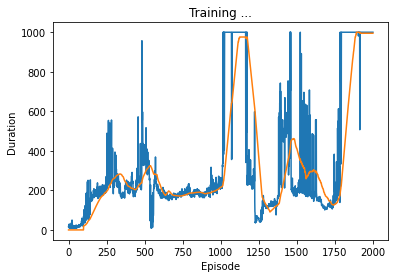

Episode 2000 
 100 episode moving avg: 994.88


In [16]:
# print results if net was trained
if episode_rewards is not None:
    plot_results(episode_rewards, 100)

episode: 4


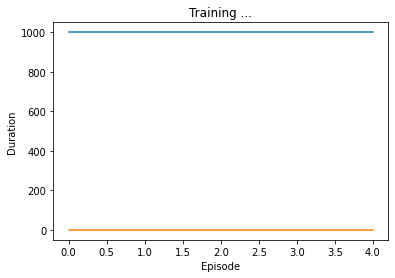

Episode 5 
 100 episode moving avg: 0.0


In [17]:
# play
episode_rewards = play(torchdevice, policy_net, 5, 1000)

best episode: 0 with duration 1000


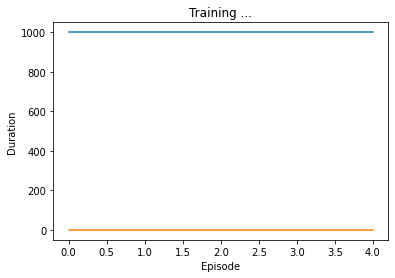

Episode 5 
 100 episode moving avg: 0.0


In [18]:
# print results of play
if episode_rewards is not None:
    plot_results(episode_rewards, 100)